## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from pathlib import Path
from PIL import Image as pil_image

In [3]:
torch.cuda.set_device(1)

In [4]:
#path = untar_data(URLs.CAMVID)
path = Path("catalyst/data/camvid_data/")
path.ls()

[PosixPath('catalyst/data/camvid_data/codes.txt'),
 PosixPath('catalyst/data/camvid_data/labels'),
 PosixPath('catalyst/data/camvid_data/images'),
 PosixPath('catalyst/data/camvid_data/models'),
 PosixPath('catalyst/data/camvid_data/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
gr_data_dir = Path('data')
gr_train_images = gr_data_dir/'train_images'
gr_test_img = gr_train_images/'mask_fill/test'

gr_train_path = gr_train_images/'mask_fill/train'
gr_train_mask = gr_train_path/'masks'
gr_train_img = gr_train_path/'images'


## Subset classes

In [7]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('catalyst/data/camvid_data/images/0001TP_008850.png'),
 PosixPath('catalyst/data/camvid_data/images/0016E5_07860.png'),
 PosixPath('catalyst/data/camvid_data/images/0016E5_07680.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('catalyst/data/camvid_data/labels/0001TP_007770_P.png'),
 PosixPath('catalyst/data/camvid_data/labels/0006R0_f02220_P.png'),
 PosixPath('catalyst/data/camvid_data/labels/0016E5_05880_P.png')]

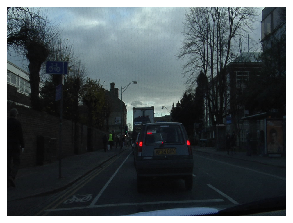

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

#### mask as image

Fastai converts to  tensor, divides by 255 by default, returns fastai.vision.image.Image

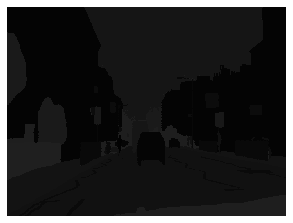

In [11]:
mask_f = lbl_names[0]
mask_i = open_image(mask_f)
mask_i.show(figsize=(5,5))

In [12]:
src_size = np.array(mask_i.shape[1:])
src_size,mask_i.data

(array([720, 960]),
 tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.1176, 0.1176, 0.1176],
          [0.0745, 0.0745, 0.0745,  ..., 0.1176, 0.1176, 0.1176],
          [0.0745, 0.0745, 0.0745,  ..., 0.1176, 0.1176, 0.1176]],
 
         [[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.1176, 0.1176, 0.1176],
          [0.0745, 0.0745, 0.0745,  ..., 0.1176, 0.1176, 0.1176],
          [0.0745, 0.0745, 0.0745,  ..., 0.1176, 0.1176, 0.1176]],
 
         [[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0

#### pillow

In [13]:
mask_f = lbl_names[0]
mask_p = pil_image.open(mask_f)
im_p = np.asarray(mask_p)
im_p

array([[ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       ...,
       [19, 19, 19, 19, ..., 30, 30, 30, 30],
       [19, 19, 19, 19, ..., 30, 30, 30, 30],
       [19, 19, 19, 19, ..., 30, 30, 30, 30],
       [19, 19, 19, 19, ..., 30, 30, 30, 30]], dtype=uint8)

In [14]:
print(f'{type(im_p)}, {im_p.shape}, {im_p}')

<class 'numpy.ndarray'>, (720, 960), [[ 4  4  4  4 ...  4  4  4  4]
 [ 4  4  4  4 ...  4  4  4  4]
 [ 4  4  4  4 ...  4  4  4  4]
 [ 4  4  4  4 ...  4  4  4  4]
 ...
 [19 19 19 19 ... 30 30 30 30]
 [19 19 19 19 ... 30 30 30 30]
 [19 19 19 19 ... 30 30 30 30]
 [19 19 19 19 ... 30 30 30 30]]


In [15]:
tmp_i = pil_image.fromarray(im_p)
tmp_i.save('temp_delete.png')

In [16]:
np.unique(im_p)

array([ 2,  4,  5,  8,  9, 10, 12, 14, 16, 17, 19, 21, 22, 24, 26, 30, 31], dtype=uint8)

In [17]:
len(np.unique(im_p).tolist())

17

#### Fastai mask display

In [18]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

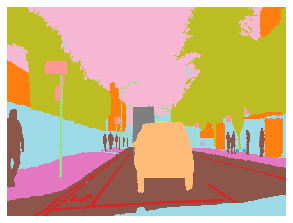

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [21]:
np.unique(mask.data.numpy())

array([ 4,  5,  8, 10, 12, 14, 16, 17, 19, 21, 22, 24, 26, 27, 29, 30, 31])

In [22]:
torch.max(mask.data)

tensor(31)

In [23]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [24]:
len(codes)

32

In [25]:
path_img

PosixPath('catalyst/data/camvid_data/images')

In [26]:
rgb_list = []
for i in range(len(codes)):
    rgb=[i,i,i]
    rgb_list.append(rgb)

In [27]:
rgb_list

[[0, 0, 0],
 [1, 1, 1],
 [2, 2, 2],
 [3, 3, 3],
 [4, 4, 4],
 [5, 5, 5],
 [6, 6, 6],
 [7, 7, 7],
 [8, 8, 8],
 [9, 9, 9],
 [10, 10, 10],
 [11, 11, 11],
 [12, 12, 12],
 [13, 13, 13],
 [14, 14, 14],
 [15, 15, 15],
 [16, 16, 16],
 [17, 17, 17],
 [18, 18, 18],
 [19, 19, 19],
 [20, 20, 20],
 [21, 21, 21],
 [22, 22, 22],
 [23, 23, 23],
 [24, 24, 24],
 [25, 25, 25],
 [26, 26, 26],
 [27, 27, 27],
 [28, 28, 28],
 [29, 29, 29],
 [30, 30, 30],
 [31, 31, 31]]

### Divide image colours by rgb

In [28]:
def convert_mask(old_mask, rgb_list, div):
    '''
    create a bytemask for pixels = rgb value to be replaced, 
    sum over all columns
    fill in pixels with new idx value
    '''
    print(f'>>convert_mask(old_mask: {old_mask.data}')
    new_mask = torch.zeros((old_mask.shape[-2],old_mask.shape[-1]))
    for idx, rgb in enumerate(rgb_list):
        rgb_mask = torch.sum(old_mask.data.view((3,-1)).permute(1,0) == tensor(rgb),dim=1)==3 
        new_mask.masked_fill_(rgb_mask.view(new_mask.shape), tensor(idx)) 
    if div: 
        new_mask.div_(len(rgb_list))
    print(f'new_mask: {new_mask.data}, max: {torch.max(new_mask)}, div: {div}, len(rgb_list): {len(rgb_list)}')
    return ImageSegment(new_mask.unsqueeze(0))

def open_mask_converted(fn:PathOrStr, div, convert_mode='RGB', after_open:Callable=None, rgb_list=rgb_list)->ImageSegment:
    '''Note we apply div after opening and conversion'''
    return convert_mask(open_image(fn, div=False, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open), rgb_list, div=div)

In [30]:
from fastai.vision.data import SegmentationProcessor
class UniqueSegmentationLabelList(ImageList):
    "ItemList for segmentation masks"
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)
    def open(self, fn): 
        return open_mask_converted(fn, div=False)
    def analyze_pred(self, pred, thresh:float=0.5): 
        return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): 
        return ImageSegment(t)

class UniqueSegmentationItemList(ImageList):
    _label_cls,_square_show_res = UniqueSegmentationLabelList,False

## Datasets

In [31]:
size = src_size//2
bs=8

In [32]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [33]:
len(src.train.x)

600

In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [35]:
data.train_ds.y[0].shape

torch.Size([1, 720, 960])

In [37]:
data.train_ds.y[0].data

tensor([[[26, 26, 26,  ..., 26, 26, 26],
         [26, 26, 26,  ..., 26, 26, 26],
         [26, 26, 26,  ..., 26, 26, 26],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [38]:
y=data.train_ds.y[0].data.numpy()
np.unique(y)

array([ 4,  5,  8, 10, 12, 14, 16, 17, 19, 21, 22, 24, 26, 27, 29, 30, 31])

In [40]:
data.train_ds.x[0].shape

torch.Size([3, 720, 960])

In [41]:
data.label_list

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: catalyst/data/camvid_data/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: catalyst/data/camvid_data/images;

Test: None

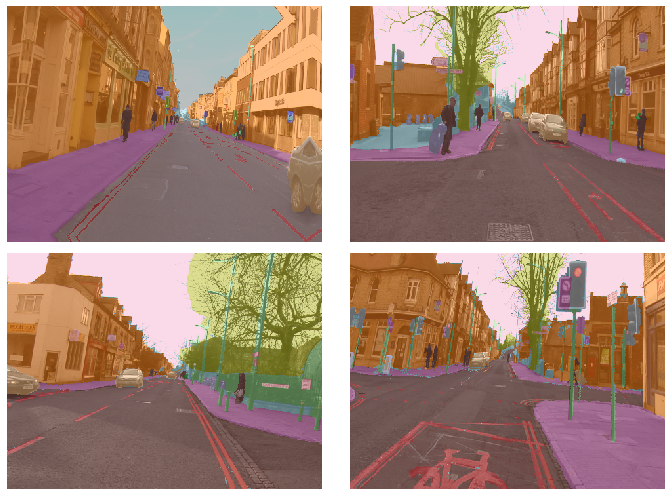

In [42]:
data.show_batch(2, figsize=(10,7))

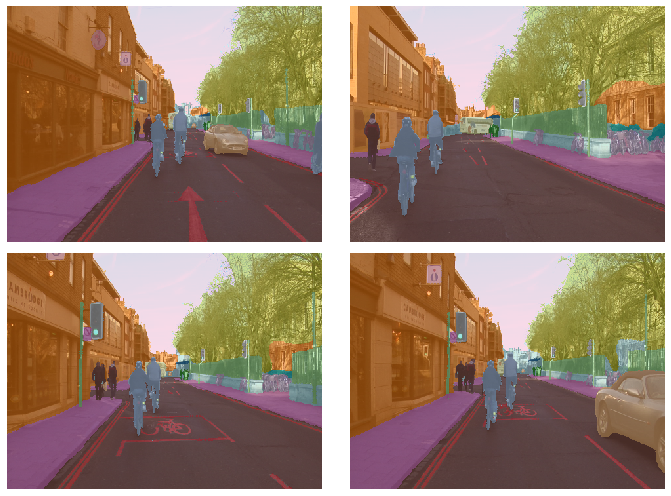

In [43]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [44]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [45]:
metrics=acc_camvid
# metrics=accuracy

In [46]:
wd=1e-2

In [47]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [48]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


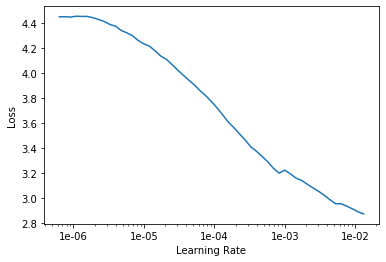

In [49]:
lr_find(learn)
learn.recorder.plot()

In [50]:
lr=3e-3

In [51]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.252799,0.892811,0.773905,00:39
1,0.842075,0.711742,0.830441,00:38
2,0.744896,0.646523,0.843222,00:37
3,1.422660,1.499431,0.565787,00:37
4,1.222260,0.918224,0.715489,00:39


In [52]:
learn.save('stage-1')

In [53]:
learn.load('stage-1');

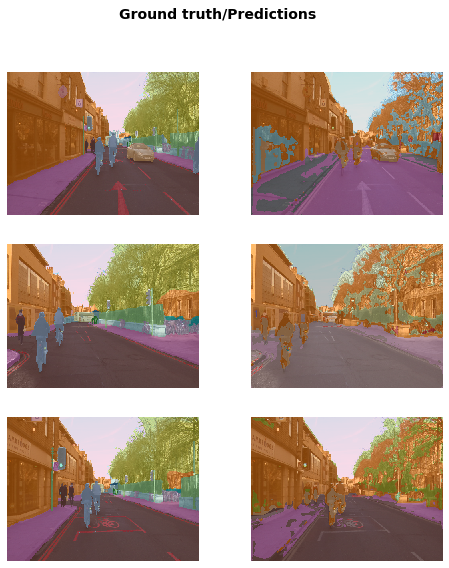

In [54]:
learn.show_results(rows=3, figsize=(8,9))

In [55]:
learn.data.classes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [57]:
from fastai.vision.interpret import SegmentationInterpretation

interp=SegmentationInterpretation.from_learner(learn)

In [58]:
top_losses, top_idxs=interp.top_losses((128,128))

RuntimeError: shape '[-1, 16384]' is invalid for input of size 17452800

In [ ]:
# show top loss
print(top_losses[top_idxs[0]])
interp.show_xyz(top_idxs[0], codes, sz=15)

In [60]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
Sky,0.977612
Road,0.951526
Building,0.875463
Sidewalk,0.725669
Car,0.467637
Tree,0.448787
Fence,0.122419
VegetationMisc,0.0499378
LaneMkgsDriv,0.019235
TrafficLight,0.00360398


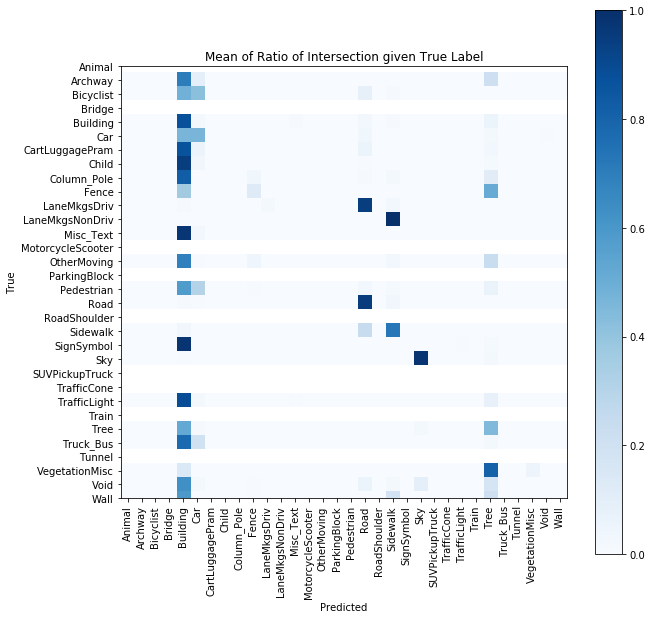

In [61]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.389135,0.334715,0.896700
2,0.377873,0.324080,0.900284
3,0.369020,0.325073,0.904146
4,0.355022,0.308820,0.912556
5,0.351138,0.313001,0.909351
6,0.347777,0.285509,0.920183
7,0.338683,0.306076,0.909899
8,0.318913,0.303712,0.915792
9,0.312038,0.276126,0.920137
10,0.311217,0.276649,0.925244


In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=3

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


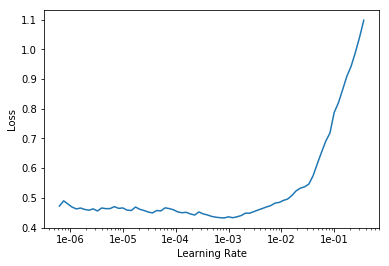

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

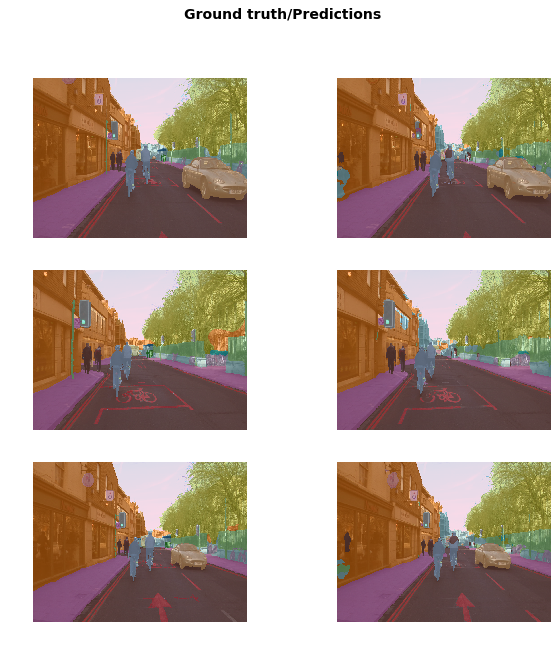

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin